In [19]:
import torch
import numpy as np
import lateral_connections as l

import importlib
importlib.reload(l)

model_path = 'models/VGG19_normalized_avg_pool_pytorch'
vm = l.VggModel(model_path, torch.device('cuda'), important_layers=['relu1_1', 'pool1', 'pool2', 'pool3', 'pool4'])
#vm = l.VggModel(model_path, torch.device('cuda'), important_layers=['relu1_1', 'pool1', 'pool2'])
model = l.LateralModel(vgg_model=vm, num_output_repetitions=4, delta=1)

def torch_transform(img):
    return img.reshape((1,) + img.shape).float()

ds = l.CustomImageDataset('images/geometric_dataset/annotations.csv', image_transform=torch_transform)

import matplotlib.pyplot as plt
from tqdm import tqdm

In [20]:
mean_h = list()
mean_s = list()
last_h = list()
last_s = list()

In [21]:
pbar = tqdm(range(1024))
for i in pbar:
    img_id = np.random.randint(len(ds))
    img, label = ds[img_id]
    pbar.set_description(f"Processing #{img_id} ({ds.labels[label]})")
    
    model.forward(img)

    mean_h.append(torch.mean(model.H).cpu().detach().numpy())
    mean_s.append(torch.mean(model.S).cpu().detach().numpy())
    last_h.append(model.S[0,0,0,-1].cpu().detach().numpy())
    last_s.append(model.H[0,0,0,-1].cpu().detach().numpy())

Processing #2380 (cylinder): 100%|███████████████████████████████████████████████| 1024/1024 [00:36<00:00, 28.42it/s]


0

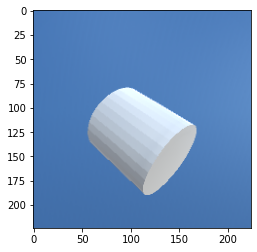

In [22]:
img_plottable = torch.swapaxes(torch.swapaxes(img[0,...], 0, 2), 0, 1).numpy().astype(int)
plt.imshow(img_plottable)

#model.forward(torch.ones(img.shape).float(), update=False)
0

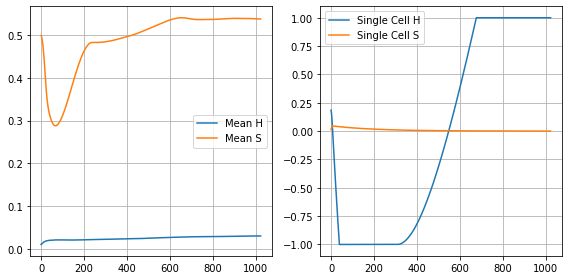

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(8,4))
axs[0].plot(mean_h, label='Mean H')
axs[0].plot(mean_s, label='Mean S')
axs[0].grid(True)
axs[0].legend()
axs[1].plot(last_h, label='Single Cell H')
axs[1].plot(last_s, label='Single Cell S')
axs[1].grid(True)
axs[1].legend()
plt.tight_layout()

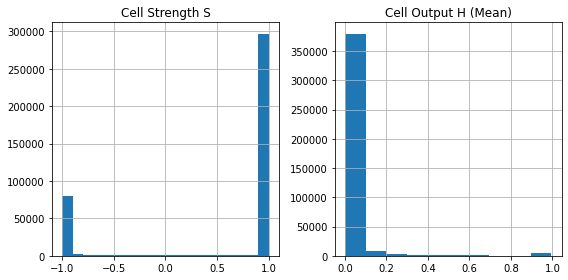

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(8,4))
axs[0].hist(model.S.cpu().detach().numpy().reshape(np.prod(model.S.shape)), bins=20)
#axs[0].set_yscale('log')
axs[0].grid(True)
axs[0].set_title('Cell Strength S')
axs[1].hist(model.H.cpu().detach().numpy().reshape(np.prod(model.H.shape)), bins=10)
#axs[1].set_yscale('log')
axs[1].grid(True)
axs[1].set_title('Cell Output H (Mean)')
plt.tight_layout()

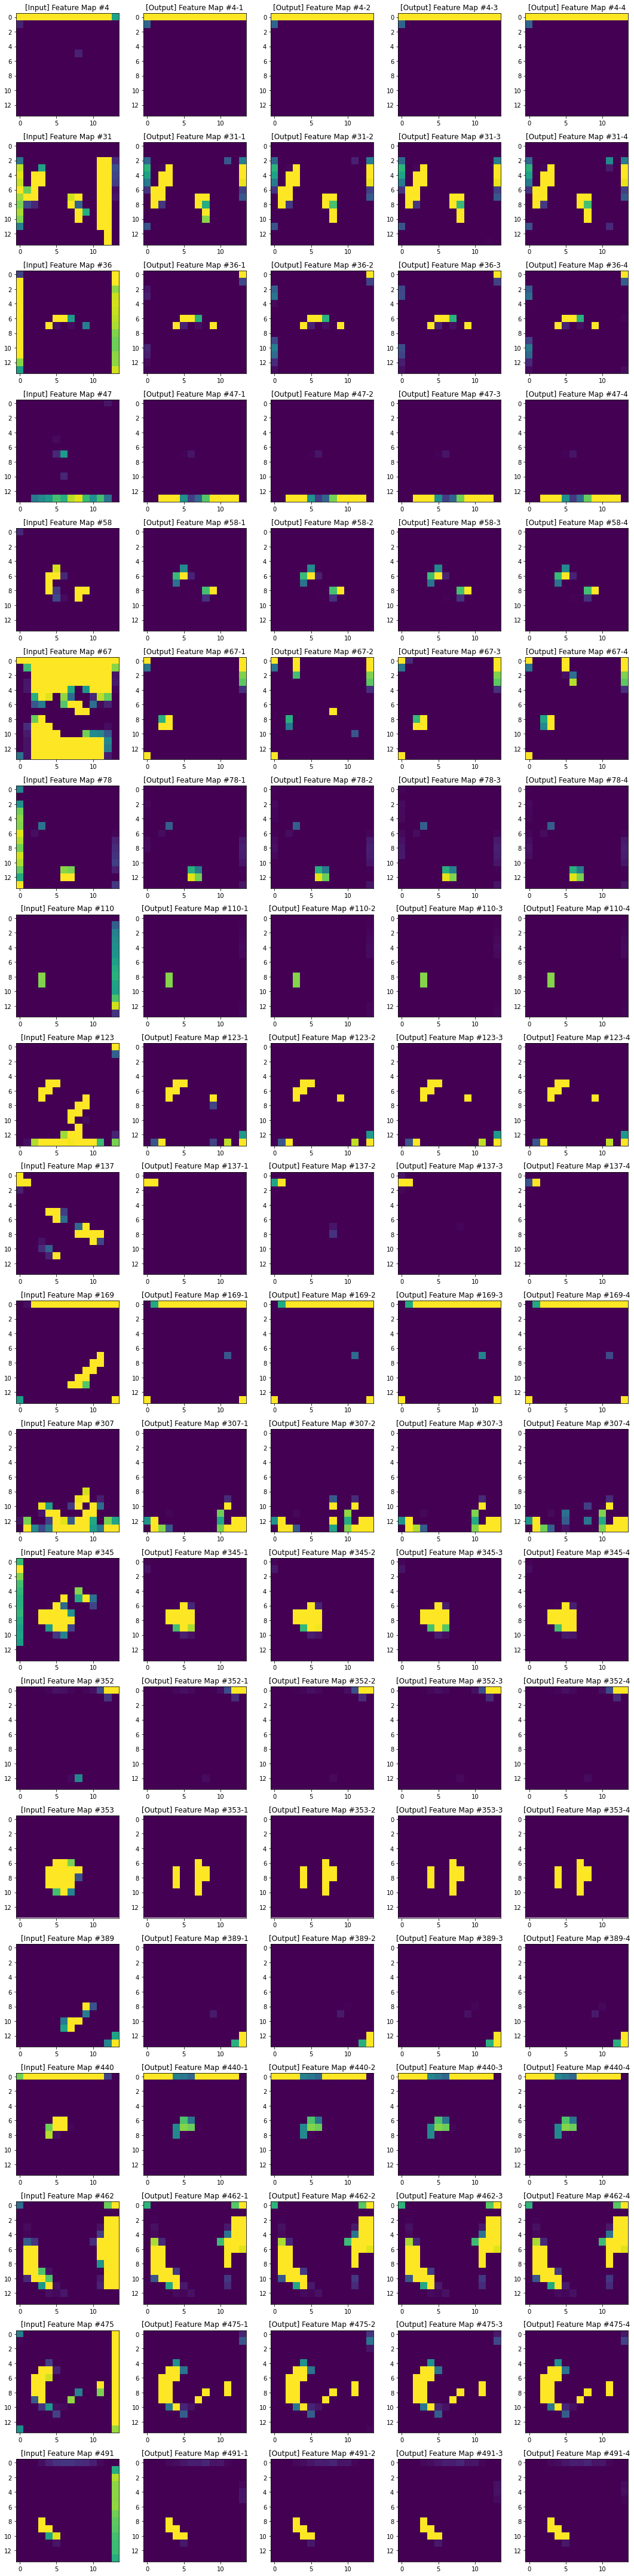

In [25]:
num_fm = 20
plot_size = 3

feature_map_idx = np.sort(np.random.choice(model.O.shape[-3], num_fm, replace=False))

fig, axs = plt.subplots(num_fm, 1 + model.num_output_repetitions, figsize=(plot_size*(1 + model.num_output_repetitions), plot_size*num_fm))
for i, fm_i in enumerate(feature_map_idx):
    axs[i][0].imshow(model.C[0, fm_i, :, :].cpu().detach().numpy(), vmin=0, vmax=1)
    axs[i][0].set_title(f"[Input] Feature Map #{fm_i}")
    
    for n in range(model.num_output_repetitions):
        axs[i][1+n].imshow(model.O[n, fm_i, :, :].cpu().detach().numpy(), vmin=0, vmax=1)
        axs[i][1+n].set_title(f"[Output] Feature Map #{fm_i}-{n+1}")
    
plt.tight_layout()
